# Autoencoder
This notebook makes use of the **Autoencoder**, which is used to reduce the dimensionality of our dataset in a non-linear way. Furthermore, we then apply **k-means Clustering** as in our last notebook in our new created **Latent Space** in lower dimension. We do so, to get rid of less important variables and achieve a better Clustering.

In [1]:
# !pip install cartopy xarray matplotlib netCDF4 torch

In [2]:
import importlib
from ipywidgets import FloatSlider
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, IntSlider
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

import sys
sys.path.append("../")
import helper_functions
importlib.reload(helper_functions)

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

## Data Loading & Preprocessing

In [3]:
ds = xr.open_dataset("/home/jovyan/spatiotemporal-mining-medsea/data/medsea.nc")

z_temp = helper_functions.preprocessing(ds, ["thetao", "so"], [50, 300, 1000], "location", -1)
X = z_temp.values
input_dimension = X.shape[1]

## The Architecture

In [4]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),
            nn.LeakyReLU(),

            nn.Linear(512, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(0.1),
            nn.LeakyReLU(),

            nn.Linear(32, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),

            nn.Linear(32, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),

            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(input_dim=input_dimension, latent_dim=3).to(device)
model.load_state_dict(torch.load("../models/AE.pth", weights_only=False))

<All keys matched successfully>

## Reconstructing
Before we do any Clustering, let's see how good the model is in reconstructing one sample.

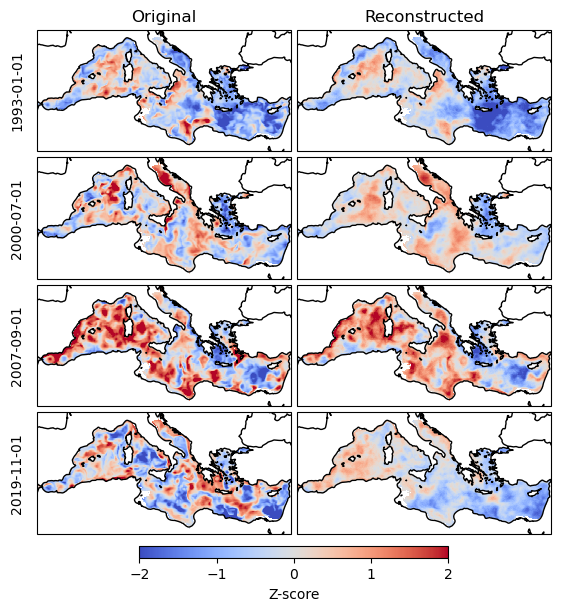

In [6]:
original_z = helper_functions.preprocessing(ds, ["thetao"], [50], "location", -1)

X_recon_all = helper_functions.reconstruct_in_batches(X, model, device, 64)
coords = original_z.location
reconstructed_z = helper_functions.reconstructed_to_stack(ds, "thetao", 50, X_recon_all, coords)

helper_functions.plot_reconstruction_comparison(
    z_stack_original=original_z,
    z_stack_recon=reconstructed_z,
    time_indices=[0, 90, 176, 322],
    cmin=-2,
    cmax=2
)

## Clustering with K-Means

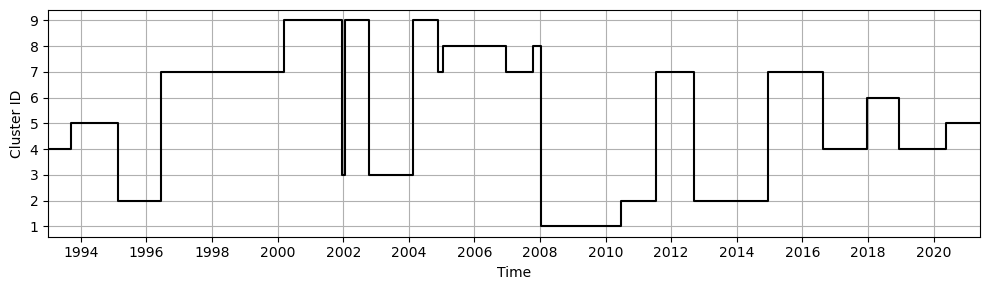

In [7]:
k=9
labels = helper_functions.apply_kmeans(X_recon_all, k)
labels += 1
np.save("../hungarian/ae.npy", labels)

helper_functions.plot_cluster_timeline(z_temp, labels)

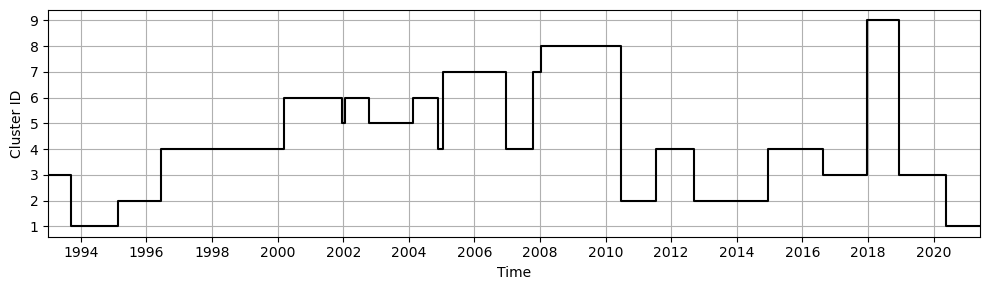

In [8]:
dict = {5: 1, 2: 2, 4: 3, 7: 4, 3: 5, 9: 6, 8: 7, 1: 8, 6: 9}

labels = np.array([dict[k] for k in labels])
helper_functions.plot_cluster_timeline(z_temp, labels)

### Depth = 50

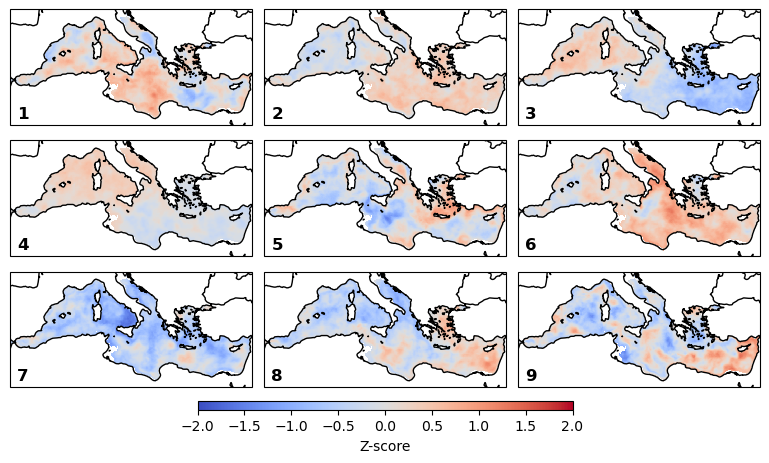

In [9]:
recon_temp_50 = helper_functions.reconstructed_to_stack(ds, "thetao", 50, X_recon_all, coords)
helper_functions.plot_average_cluster(recon_temp_50, labels, -2, 2)

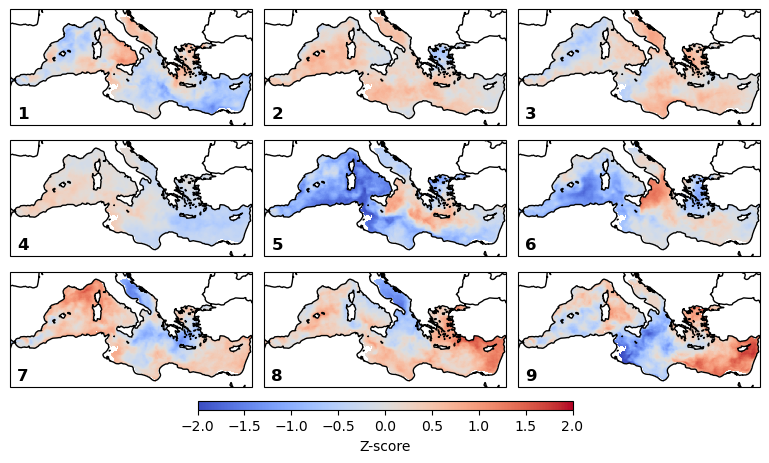

In [10]:
recon_so_50 = helper_functions.reconstructed_to_stack(ds, "so", 50, X_recon_all, coords)
helper_functions.plot_average_cluster(recon_so_50, labels, -2, 2)

### Depth = 300

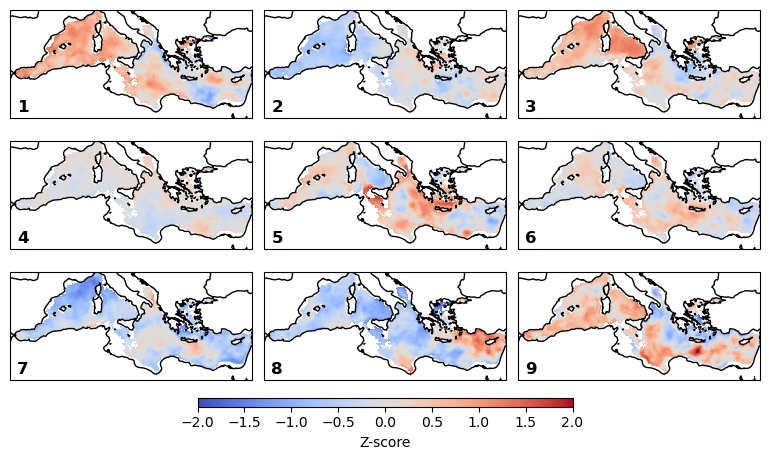

In [11]:
coords = helper_functions.preprocessing(ds, ["thetao"], [300], "location", -1).location
recon_temp_300 = helper_functions.reconstructed_to_stack(ds, "thetao", 300, X_recon_all, coords)
helper_functions.plot_average_cluster(recon_temp_300, labels, -2, 2)

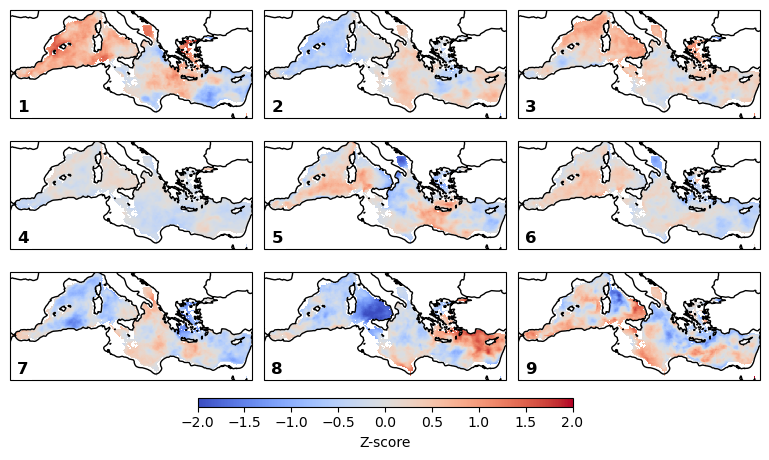

In [12]:
recon_so_300 = helper_functions.reconstructed_to_stack(ds, "so", 300, X_recon_all, coords)
helper_functions.plot_average_cluster(recon_so_300, labels, -2, 2)

### Depth = 1000

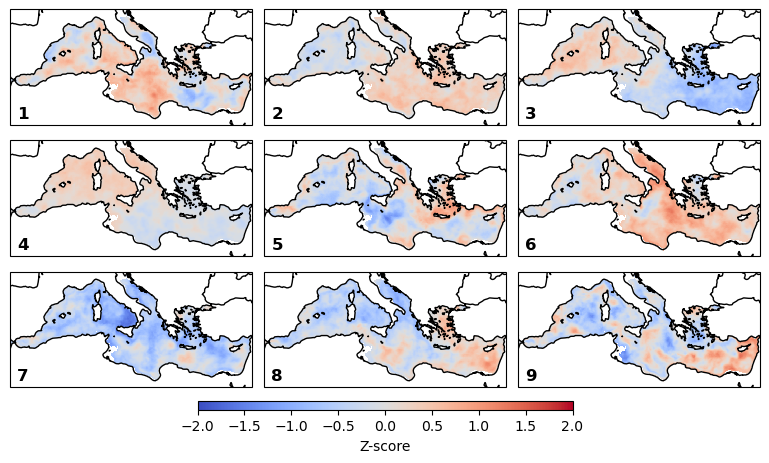

In [13]:
coords = helper_functions.preprocessing(ds, ["thetao"], [1000], "location", -1).location
recon_temp_1000 = helper_functions.reconstructed_to_stack(ds, "thetao", 1000, X_recon_all, coords)
helper_functions.plot_average_cluster(recon_temp_50, labels, -2, 2)

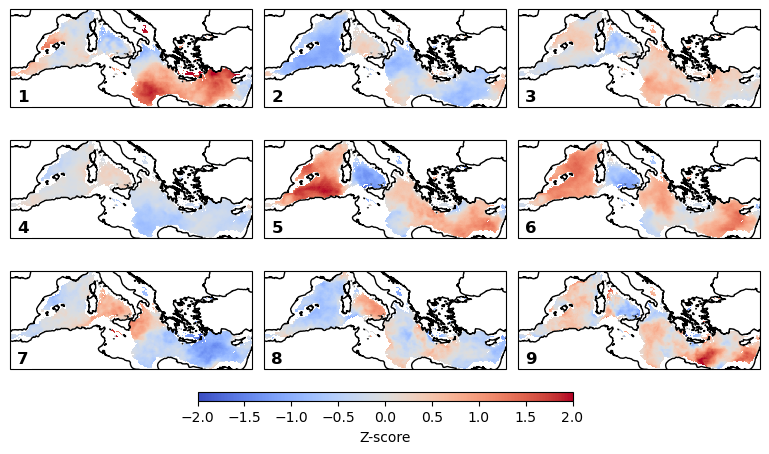

In [14]:
recon_so_1000 = helper_functions.reconstructed_to_stack(ds, "so", 1000, X_recon_all, coords)
helper_functions.plot_average_cluster(recon_so_1000, labels, -2, 2)

## Calculating the Loss per Cluster

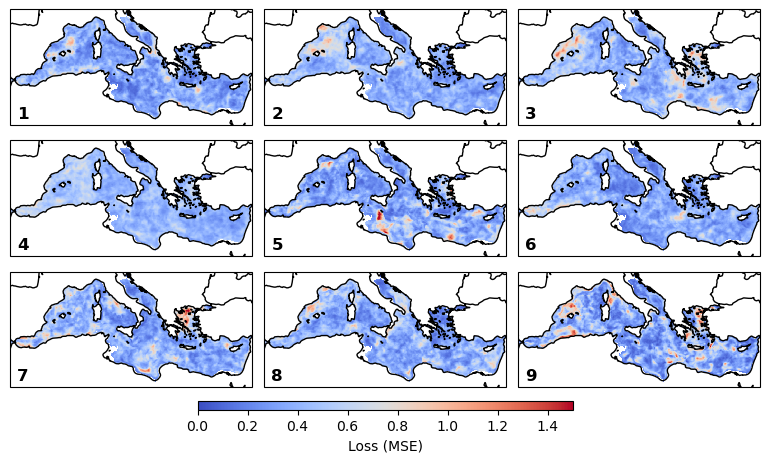

In [15]:
helper_functions.plot_average_loss_map_from_data(original_z, reconstructed_z, labels, 0, 1.5)